In [1]:
import torch.nn as nn
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [355]:
# Loading the raw data (pixel data)
raw_train_data = pd.read_csv("../../../../DeepLearning/Datasets/time_series_train.csv")
raw_test_data = pd.read_csv("../../../../DeepLearning/Datasets/time_series_test.csv")

In [454]:
raw_all_data = pd.concat((raw_train_data,raw_test_data)).reset_index(drop=True)

In [462]:
def plot_data(raw_data,store=0,product=0):
    tmp = raw_data[(raw_data["store"]==store) & (raw_data["product"]==product)].reset_index(drop=True)
    plt.plot(tmp["number_sold"])

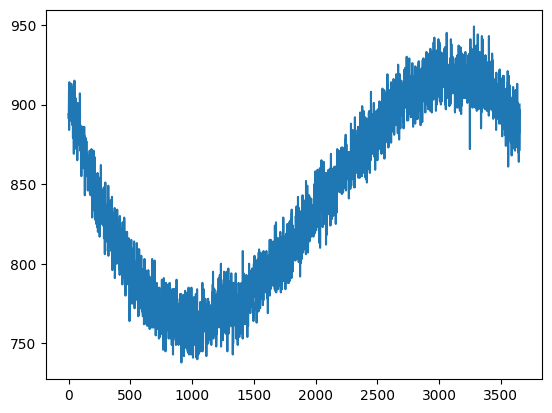

In [511]:
plot_data(raw_all_data,product=2,store=5)

In [275]:
def format_data(raw_data,window=10, store=0,product=0):
    tmp = raw_data[(raw_data["store"]==store) & (raw_data["product"]==product)].to_numpy()[:,-1].astype(np.float64)
    x_ = []
    y_ = []
    for i in range(len(tmp)-window):
        x_.append(tmp[i:i+window])
        y_.append(tmp[i+window])
    return np.array(x_).reshape((-1,window,1)),np.array(y_).reshape((-1,1))

In [513]:
x_train,y_train = format_data(raw_train_data,window=100,store=5,product=2)
x_train = x_train / 1000
y_train = y_train / 1000

In [413]:
class MyLSTM(nn.Sequential):
    def __init__(self,in_features,hidden_size,layer_dim,output_features):
        super(nn.Sequential,self).__init__()
        self.hidden_size = hidden_size
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(in_features,hidden_size,layer_dim,batch_first=True)
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(hidden_size,output_features)
    def forward(self, x,state=(None,None)):
        h0,c0 = state
        if h0 is None:
            h0 = torch.zeros((self.layer_dim,x.shape[0],self.hidden_size))
        if c0 is None:
            c0 = torch.zeros((self.layer_dim,x.shape[0],self.hidden_size))
        o, (hn,cn) = self.lstm(x,(h0.detach(),c0.detach()))
        return self.flatten(self.linear(hn[-1])), (hn,cn)

In [512]:
# Creating our model
model = MyLSTM(1,20,1,1)

# Defining our loss function
loss_fn = nn.MSELoss()

lr = 0.1
# Defining our optimizer
optim = torch.optim.Adam(model.parameters(),lr=lr)

In [418]:
optim = torch.optim.Adam(model.parameters(),lr=0.001)

In [514]:
N = len(x_train)
epochs = 400
# Start training for #epochs
for epoch in range(epochs):
    # Setting all grads (of all parameters) to zero
    optim.zero_grad()
    # Converting our inputs and outputs to tensor
    x_ = torch.tensor(x_train).float()
    y_ = torch.tensor(y_train).float()
    # Forward
    o,_ = model(x_)
    # Calculate loss
    loss = loss_fn(o,y_)
    # Backward
    loss.backward()
    # Update parameters using the calculated gradients
    optim.step()
    if epoch % 40 == 0:
        print(loss.item())
    if epoch % 200 == 0:
        optim = torch.optim.Adam(model.parameters(),lr=lr/10)

0.5391964912414551
0.0024065859615802765
0.0022435069549828768
0.00211863755248487
0.0019479762995615602
0.0017023924738168716
0.0015714381588622928
0.0009122705087065697
0.00018004051526077092
0.00011526325397426262


In [515]:
x_test,_ = format_data(raw_all_data,window=100,store=5,product=2)

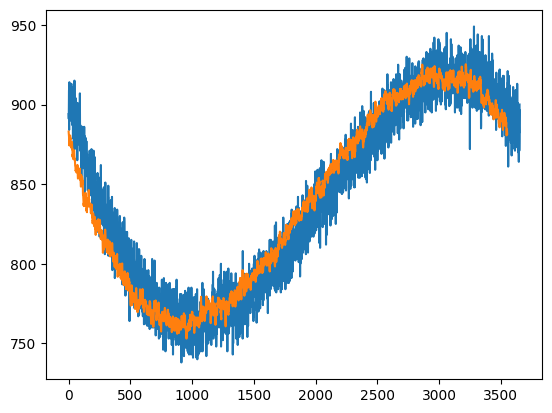

In [516]:
o,_= model(torch.tensor(x_test/1000).float())
plot_data(raw_all_data,product=2,store=5)
plt.plot(o.detach().numpy() * 1000)